The goal of this project is to understand this traffic better, in particular the volume and distribution of events, and to develop ideas how to increase the links' clickrates. With that in mind, please analyze the data using the Python libraries Pandas and SciPy where indicated, providing answers to the presented questions:

1. [Pandas] How many total pageview events did the links in the provided dataset receive in the full period, how many per day?
2. [Pandas] What about the other recorded events?
3. [Pandas] Which countries did the pageviews come from?
4. [Pandas] What was the overall click rate (clicks/pageviews)?
5. [Pandas] How does the clickrate distribute across different links?
6. [Pandas & SciPy] Is there any correlation between clicks and previews on a link? Is it significant? How large is the effect? Make sure to at least test for potential linear as well as categorical (think binary) relationships between both variables.

The data set provided ('traffic'.csv) contains web traffic data ("events") from a few different pages ("links") over a period of 7 days including various categorical dimensions about the geographic origin of that traffic as well as a page's content: 'isrc'.

In [1]:
# import libraries, pandas and scipy are required, numpy will come in handy
import pandas as pd
import numpy as np

from scipy import stats

In [2]:
# modify this to point to the downloaded CSV file
CSV_FILEPATH = "traffic.csv"
# load the data set
df = pd.read_csv(CSV_FILEPATH)

In [3]:
# (#columns, #rows)
df.shape

(226278, 9)

In [4]:
# printing the first five rows
df.head()

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8


**Question 1
[Pandas] How many total pageview events did the links in the provided dataset receive in the full period, how many per day?**

To filter the data set to contain only the pageview events and then to read the number of rows in the filtered data set.

In [5]:
# the total pageview events is the number of rows where 'event' = 'pageview'
df[df["event"] == "pageview"].shape[0]

142015

We group the pageview events by the date and then count their occurrence.

In [6]:
# 1. filter only for 'pageview' events
# 2. group by the date
# 3. keep only the 'event' column, and specify a 'count' aggregation
df[df["event"] == "pageview"].groupby(by="date")["event"].count()

date
2021-08-19    22366
2021-08-20    21382
2021-08-21    21349
2021-08-22    20430
2021-08-23    18646
2021-08-24    18693
2021-08-25    19149
Name: event, dtype: int64

**Question 2
[Pandas] What about the other recorded events?**

In [7]:
# get the set of recorded events in the data
recorded_events = set(df["event"].unique())
# remove the 'pageview' event
recorded_events.remove("pageview")
recorded_events

{'click', 'preview'}

In [8]:
# loop over each event
for recorded_event in recorded_events:
    # get the total number of occurrences
    total_events = df[df["event"] == recorded_event].shape[0]
    print("Total number of", recorded_event, "events is", total_events, "\n")
    # group by the date and aggregate by count
    data_set = df[df["event"] == recorded_event].groupby(by="date")["event"].count()
    print(recorded_event, "event distribution per day:\n")
    print(data_set, "\n")

Total number of preview events is 28531 

preview event distribution per day:

date
2021-08-19    3788
2021-08-20    4222
2021-08-21    4663
2021-08-22    4349
2021-08-23    3847
2021-08-24    3840
2021-08-25    3822
Name: event, dtype: int64 

Total number of click events is 55732 

click event distribution per day:

date
2021-08-19    9207
2021-08-20    8508
2021-08-21    8071
2021-08-22    7854
2021-08-23    7315
2021-08-24    7301
2021-08-25    7476
Name: event, dtype: int64 



**Question 3
[Pandas] Which countries did the pageviews come from?**

In [10]:
# filter for the proper event
df_q3 = df[df["event"] == "pageview"]
# or alternatively, you can loop over the array provided by df.unique() and print them all
pd.DataFrame(data=df_q3["country"].dropna().unique(), columns=["Country"])

,Country
0,Saudi Arabia
1,United States
2,Ireland
3,United Kingdom
4,France
...,...
206,Afghanistan
207,Central African Republic
208,Guernsey
209,Sint Maarten


**Question 4
[Pandas] What was the overall click rate (clicks/pageviews)?**

The click rate is the number of clicks that a page has received (event = 'click') divided by the number of times it has been shown (event = 'pageview').

In [11]:
# filter only 'click' events and group them by the 'linkid' to get their count,
# i.e., number of clicks on each link
link_clicks = df[df["event"] == "click"].groupby(by="linkid")["event"].count().reset_index()
link_clicks = link_clicks.rename(columns={
    "event": "clicks" # rename column for easier manipulation
})
# do the same for the 'pageview' events
pageviews = df[df["event"] == "pageview"].groupby(by="linkid")["event"].count().reset_index()
pageviews = pageviews.rename(columns={
    "event": "pageviews"
})

In [12]:
link_clicks.head()

,linkid,clicks
0,00126b32-0c35-507b-981c-02c80d2aa8e7,2
1,004b9724-abca-5481-b6e9-6148a7ca00a5,1
2,0063a982-41cd-5629-96d0-e1c4dd72ea11,2
3,006af6a0-1f0d-4b0c-93bf-756af9071c06,8
4,00759b81-3f04-4a61-b934-f8fb3185f4a0,3


In [13]:
pageviews.head()

,linkid,pageviews
0,00073307-ae96-5089-a117-4783afb42f8e,2
1,00126b32-0c35-507b-981c-02c80d2aa8e7,2
2,0018cfff-50a1-5984-9715-01ef2d11a49a,1
3,0033934b-5d16-5a06-af58-d087bcdd3680,1
4,0034d6cf-3bd8-5ffe-aafc-b3959fc48608,1


In [14]:
# pd.merge() does a database-style join of the two dataframes
df_q4 = pd.merge(left=link_clicks, right=pageviews, on="linkid", how="inner")

In [15]:
# define a new column of the 'click_rate'
df_q4["click_rate"] = df_q4["clicks"] / df_q4["pageviews"]

In [16]:
df_q4

,linkid,clicks,pageviews,click_rate
0,00126b32-0c35-507b-981c-02c80d2aa8e7,2,2,1.000000
1,004b9724-abca-5481-b6e9-6148a7ca00a5,1,1,1.000000
2,0063a982-41cd-5629-96d0-e1c4dd72ea11,2,3,0.666667
3,006af6a0-1f0d-4b0c-93bf-756af9071c06,8,36,0.222222
4,00759b81-3f04-4a61-b934-f8fb3185f4a0,3,4,0.750000
...,...,...,...,...
2248,ffd8d5a7-91bc-48e1-a692-c26fca8a8ead,29,84,0.345238
2249,fff38ca0-8043-50cd-a5f1-f65ebb7105c5,1,1,1.000000
2250,fff84c0e-90a1-59d8-9997-adc909d50e16,1,1,1.000000
2251,fffc17a7-f935-5d3e-bd3e-d761fd80d479,1,2,0.500000


**Question 5
[Pandas] How does the clickrate distribute across different links?**

In [17]:
df_q4["click_rate"].describe()

count    2253.000000
mean        0.809920
std         1.958030
min         0.090909
25%         0.500000
50%         1.000000
75%         1.000000
max        92.300000
Name: click_rate, dtype: float64

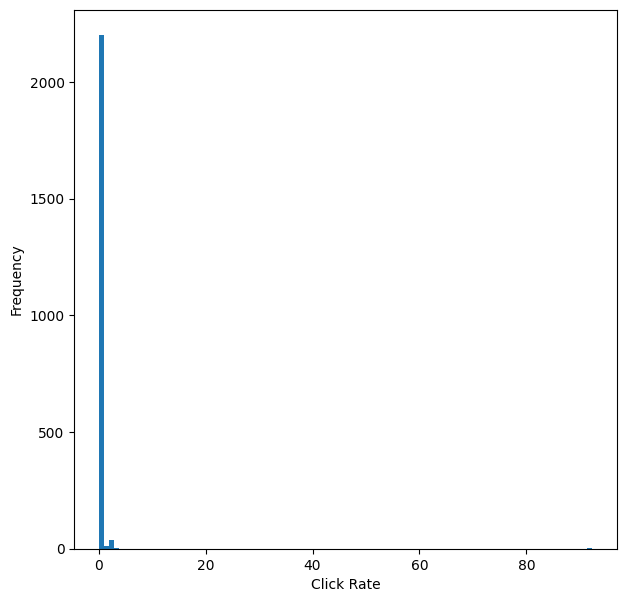

In [18]:
ax = df_q4["click_rate"].plot(kind="hist", figsize=(7, 7), bins=100)
_ = ax.set_xlabel("Click Rate")

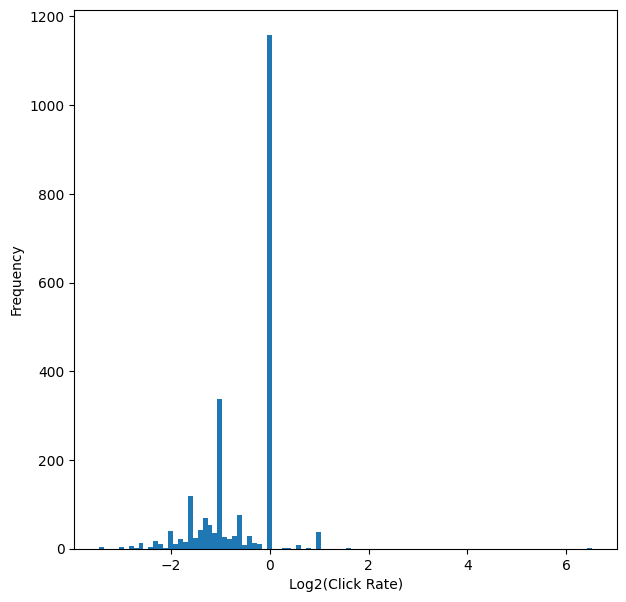

In [19]:
# because the data is highly skewed, it makes more sense to plot the log of it
df_q4["click_rate_log2"] = np.log2(df_q4["click_rate"])
ax = df_q4["click_rate_log2"].plot(kind="hist", figsize=(7, 7), bins=100)
_ = ax.set_xlabel("Log2(Click Rate)")

We observe an enormous spike at the 0 meaning that the actual click rate was 1, implying that there are many links that have been viewed and clicked on exactly once. There are also, many links that have been viewed many times but clicked on fewer (values less than zero). Remember, this plots the logarithm of the actual values, so there is an extra math step in the interpretation here.

**Question 6
[Pandas & SciPy] Is there any correlation between clicks and previews on a link? Is it significant? How large is the effect? Make sure to at least test for potential linear as well as categorical (think binary) relationships between both variables.**

Pearson's correlation coefficient is a measure of linear correlation between two data sets. It takes its value in the range of [-1, 1] and the further it is from zero, the more significant the correlation is.

In [20]:
# filter only events that are relevant to the question
df_q6 = df[df["event"].isin(["click", "preview"])]

In [21]:
df_q6.describe()

,event,date,country,city,artist,album,track,isrc,linkid
count,84263,84263,84261,84261,84252,84262,84262,82036,84263
unique,2,7,206,8137,1549,2003,2155,628,2286
top,click,2021-08-19,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
freq,55732,12995,18461,8893,15666,15666,15666,15666,15666


In [22]:
# filter only 'click' events and group them by the 'linkid' to get their count,
# i.e., number of clicks on each link
link_clicks = df[df["event"] == "click"].groupby(by="linkid")["event"].count().reset_index()
link_clicks = link_clicks.rename(columns={
    "event": "clicks" # rename column for easier manipulation
})
# do the same for the 'preview' events
previews = df[df["event"] == "preview"].groupby(by="linkid")["event"].count().reset_index()
previews = previews.rename(columns={
    "event": "previews"
})

In [23]:
# perform two database-style joins to append the
# number of link clicks and previews to each row
df_q6 = pd.merge(left=df_q6, right=link_clicks, how="left", on="linkid")
df_q6 = pd.merge(left=df_q6, right=previews, how="left", on="linkid")

In [26]:
df_q6.dropna(subset=["clicks", "previews"], inplace=True)
df_q6

,event,date,country,city,artist,album,track,isrc,linkid,clicks,previews
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2,1187.0,718.0
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd,69.0,30.0
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
...,...,...,...,...,...,...,...,...,...,...,...
84258,preview,2021-08-23,United States,Brentwood,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
84259,preview,2021-08-23,Saudi Arabia,Riyadh,Evanescence,Fallen,Bring Me To Life,USWU30200093,0ea9f8bf-a144-42bd-a7b0-124e73914da4,20.0,14.0
84260,preview,2021-08-23,Ukraine,Kyiv,Miscél,when you left,when you left,QM42K1907890,2fc15e8b-83aa-40ee-9f9d-5d96c6d4356c,235.0,145.0
84261,preview,2021-08-23,Saudi Arabia,Khamis Mushait,Anne-Marie,Beautiful,Beautiful,GBAHS2100225,522da5cc-8177-4140-97a7-a84fdb4caf1c,2109.0,1605.0


Finally, we calculate the correlation coefficient with both pandas and scipy.

In [27]:
df_q6.corr()

<ipython-input-27-6cdd56f99857>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_q6.corr()


,clicks,previews
clicks,1.000000,0.998713
previews,0.998713,1.000000


In [28]:
stats.pearsonr(x=df_q6["clicks"], y=df_q6["previews"])

PearsonRResult(statistic=0.9987125072008585, pvalue=0.0)

Almost perfectly positive correlation between the number of clicks and previews which seems logical; given that the one is actually dependent on the other (can't have clicks without previews and vice versa).

In [ ]:
# We can quantify the relationship between categorical variables in similar manner as with numerical variables.
categorical_columns = [
    "country",
    "city",
    "artist",
    "album",
    "track"
]
factorized_df = df_q6[categorical_columns] \
                     .apply(lambda x: pd.factorize(x)[0]) \
                     .corr()
factorized_df

We observe a high positive correlation between album, artist, and track and almost no correlation between other variables. This is again expected, since those variables are naturally dependent, i.e., each track belongs to an album and is performed by an artist.